In [ ]:
# normalize Fitness: L (upper bound) - Best Known (Lower Bound)
# normalize LB: Theoretical Minimum (lower bound) - Best Known (Upper Bound)
# average over all instances
# plot LB + Fitness

In [1]:
import csv

def load_data(bounds, best_known):
    data = dict()
    with open(bounds) as bounds_file:
        bounds_data = csv.reader(bounds_file, delimiter=';')
        for row in bounds_data:
            if row[0] not in data:
                data[row[0]] = dict()
            data[row[0]]['lb'] = int(row[1])
            data[row[0]]['ub'] = int(row[2])
    with open(best_known) as best_known_file:
        best_known_data = csv.reader(best_known_file, delimiter=';')
        for row in best_known_data:
            if row[0] not in data:
                data[row[0]] = dict()
            data[row[0]]['f'] = float(row[1])
    return data

In [2]:
data = load_data('bounds.txt', 'best_known_curated.txt')

In [3]:
#data

In [4]:
def normalize(x, lb, ub):
    if lb == ub:
        return 1.0
    return (x - lb) / (ub - lb)

In [5]:
import pandas as pd
exact_path = r'C:\Users\huda\Downloads\results'#r'/home/dhu/Downloads/results'
exact_files = ['results_cplex_cp.txt', 'results_cplex_lp_rewritten.txt', 'results_gurobi.txt', 'results_hexaly_rewritten.txt', 'results_ortools.txt']
all = []
for file in exact_files:
    file_content = pd.read_csv(exact_path + '/' + file, names=['name','optimization_status','fitness_value','lower_bound', 'runtime', 'result_vector1', 'result_vector2', 'result_vector3', 'peak_cpu', 'peak_ram', 'resource_history', 'best_result_history'], sep=';')#, converters={'best_result_history': pd.eval})
    content_data = pd.DataFrame(file_content)
    all.append(content_data)
results = dict()
results['cplex_cp'] = all[0]
results['cplex_lp'] = all[1]
results['gurobi'] = all[2]
results['hexaly'] = all[3]
results['ortools'] = all[4]
p = r'C:\Users\huda\Downloads\all\all\fjssp_w\results_gurobi.txt'
for file in exact_files:
    file_content = pd.read_csv(p, names=['name','optimization_status','fitness_value','lower_bound', 'runtime', 'result_vector1', 'result_vector2', 'result_vector3', 'peak_cpu', 'peak_ram', 'resource_history', 'best_result_history'], sep=';')#, converters={'best_result_history': pd.eval})
    content_data = pd.DataFrame(file_content)
    results['gurobi'] = content_data
# TODO: add GA

In [6]:
ga_path = r'C:\Users\huda\Downloads\paper_results\paper_results\fjssp-w\ga_best.txt'
file_content = pd.read_csv(ga_path, names=['name','optimization_status','fitness_value','lower_bound', 'runtime', 'result_vector1', 'result_vector2', 'result_vector3', 'peak_cpu', 'peak_ram', 'resource_history', 'best_result_history'], sep=';')#, converters={'best_result_history': pd.eval})
data_content = pd.DataFrame(file_content)
all.append(data_content)
results['ga'] = data_content

In [7]:
def normalize_history(history, bounds):
    result = []
    m = max([d[1] for d in history])
    for i in range(len(history)):
        if len(history[i]) == 2:
            history[i] = (history[i][0], history[i][1], 0.0)

        if history[i][1] == float('inf'):
            history[i] = (history[i][0], bounds['ub'], history[i][2])

        if history[i][2] == -float('inf'):
            history[i] = (history[i][0], history[i][1], bounds['lb'])

        f = normalize(history[i][1], bounds['lb'], bounds['ub'])
        lb = normalize(history[i][2], bounds['lb'], bounds['ub'])
        result.append([history[i][0], f, lb])
    return result

In [8]:
def trim_ga_data(history, bounds):
    history = history.replace('inf', 'float("inf")') # NOTE: should not be necessary for GA
    data = eval(history)
    data = [d for d in data if d > 0]
    time_step = 1200 / len(data)
    result = []
    prev = -1
    for i in range(len(data)):
        if data[i] != prev:
            result.append((time_step * i, data[i], bounds['lb']))
    return data

In [9]:
normalized_data = dict()
for solver in results.keys():
    #if solver == 'gurobi':
    #    continue # TODO: use other gurobi file + re-parse GA results
    normalized_data[solver] = dict()
    for index, row in results[solver].iterrows():
        if row['name'].startswith('Error'):
            continue
        name = row['name'].split('_')
        if len(name) == 1:
            name = name[0]
        else:
            name = ''.join(name[1:-1])
        history = row['best_result_history']
        history = history.replace('inf', 'float("inf")')
        history = eval(history)
        normalized = normalize_history(history, data[name])
        normalized_data[solver][name] = normalized

In [10]:
#normalized_data

In [11]:
def get_values_at_time(data, time): # note: should be modified binary search
    result = data[-1]
    i = 0
    while i < len(data) and data[i][0] <= time:
        result = data[i]
        i+=1
    return result

def get_all_timestamps(data, instance):
    timestamps = dict()
    for solver in data:
        timestamps[solver] = []
        if instance in data[solver]:
            timestamps[solver] = [data[solver][instance][i][0] for i in range(len(data[solver][instance]))]
        timestamps[solver].sort()# just to make sure
    return timestamps

def get_timestamps_all_instances(data):
    instances = list(data['cplex_cp'].keys())
    result = dict()
    for solver in data:
        result[solver] = dict()
        for instance in instances:
            result[solver][instance] = get_all_timestamps(data, instance)
    return result

In [12]:
normalized_data.keys()

dict_keys(['cplex_cp', 'cplex_lp', 'gurobi', 'hexaly', 'ortools', 'ga'])

In [13]:
timestamps = get_timestamps_all_instances(normalized_data)

In [14]:
def get_average_timelines(data, timestamps):
    instances = list(data['cplex_cp'].keys())
    result = dict()
    for solver in data:
        result[solver] = dict()
        for instance in instances:
            print(f'Processing: {instance}')
            result[solver][instance] = []
            times = timestamps[solver][instance]
            for timestamp in times[solver]:
                f = 0
                lb = 0
                count = 0
                for inner_solver in data:
                    if instance in data[inner_solver]:
                        values = get_values_at_time(data[inner_solver][instance], timestamp)
                        if values[1] != float('inf') and values[2] != -float('inf'):
                            f += values[1] # TODO: double check order
                            lb += values[2]
                            count += 1
                if count > 0:
                    f = float(f)/float(count)
                    lb = float(lb)/float(count)
                else:
                    f = float('inf')
                    lb = -float('inf')
                result[solver][instance].append([timestamp, f, lb])
    return result

def get_timestamps(timestamps, solver):
    data = timestamps[solver]
    times = []
    for instance in data:
        times.extend(data[instance][solver])
    times = list(set(times))
    times.sort()
    #if 1200 not in times:
    #    times.append(1200)
    return times

def get_average_timelines_test(data, timestamps):
    results = dict()
    for solver in data:
        results[solver] = []
        times = get_timestamps(timestamps, solver)
        instances = data[solver]
        for time in times:
            results[solver].append([time, 0.0, 0.0])
            count = 0
            for instance in instances:
                values = get_values_at_time(instances[instance], time)
                if values[1] == float('inf'):
                    values[1] = 1.0#bounds[instance]['ub']
                if values[2] == -float('inf'):
                    values[2] = 0.0#bounds[instance]['lb']
                # fitness = Horizon, lower bound = minimal makespan
                if values[1] != float('inf') and values[2] != -float('inf'):
                    results[solver][-1][1] += values[1]
                    results[solver][-1][2] += values[2]
                    count += 1
            if count > 0:
                results[solver][-1][1] = float(results[solver][-1][1])/float(count)
                results[solver][-1][2] = float(results[solver][-1][2])/float(count)
            else:
                results[solver][-1][1] = 1.0#average_ub#bounds[instance]['ub']#float('inf')
                results[solver][-1][2] = 0.0#average_lb
    return results
        

In [15]:
timelines = get_average_timelines_test(normalized_data, timestamps)

In [16]:
#timelines = get_average_timelines(normalized_data, timestamps)

In [17]:
#timelines

In [18]:
timelines['cplex_cp'][-1]

[1199.79, 0.04911194547495695, 0.0030265088839057912]

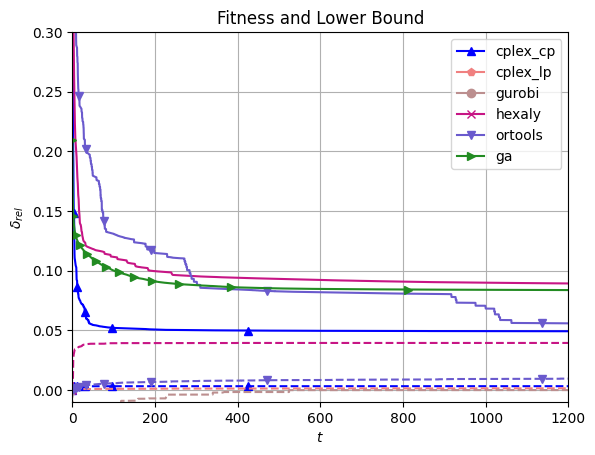

In [19]:
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
figure = plt.figure()
markers = {
    'cplex_cp': '^',
    'ortools': 'v',
    'hexaly': 'x',
    'ga': '>', # ga_best
    'ga_average': '<',
    'gurobi': 'o',
    'cplex_lp': 'p',
}
markerson = 3000
colors = {
    'cplex_cp': 'blue',
    'ortools': 'slateblue',
    'hexaly': 'mediumvioletred',
    'ga': 'forestgreen', # ga_best
    'ga_average': 'limegreen',
    'gurobi': 'rosybrown',
    'cplex_lp': 'lightcoral',
}
i = 0
for solver in timelines:
    t = [x[0] for x in timelines[solver]]
    f = [x[1] for x in timelines[solver]]
    lb = [x[2] for x in timelines[solver]]
    plt.plot(t, f, label=f'{solver}', linestyle='solid', c=colors[solver], marker=markers[solver], markevery=markerson)
    plt.plot(t, lb, linestyle='dashed', c=colors[solver], marker=markers[solver], markevery=markerson)
    i+=1
plt.title('Fitness and Lower Bound')
plt.ylim(-0.01, 0.3)
plt.xlim(-0.01, 1200.01)
plt.xlabel('$t$')
plt.ylabel('$\delta_{rel}$')
#plt.yscale('log')
plt.legend()
plt.show()

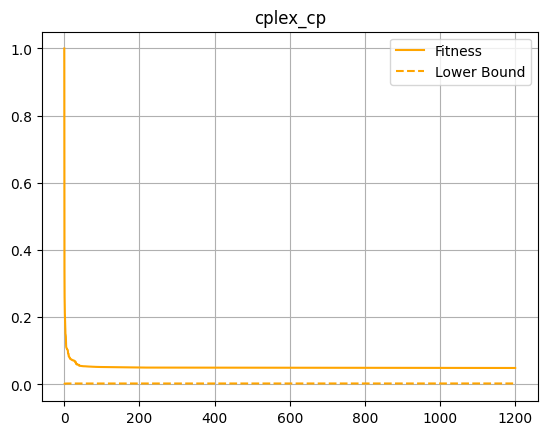

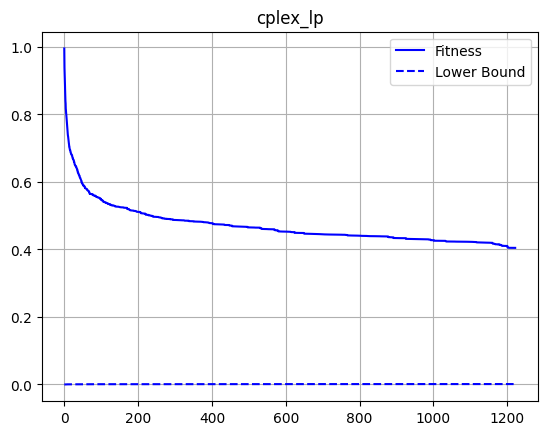

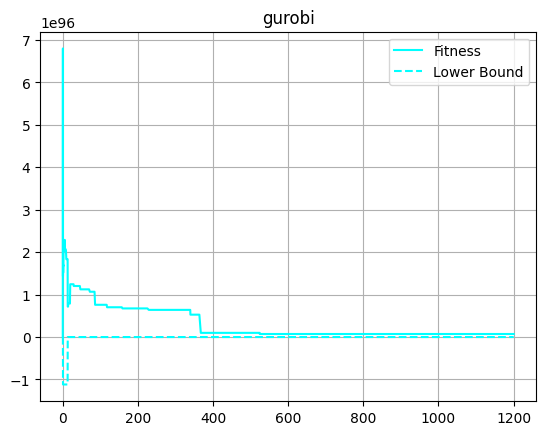

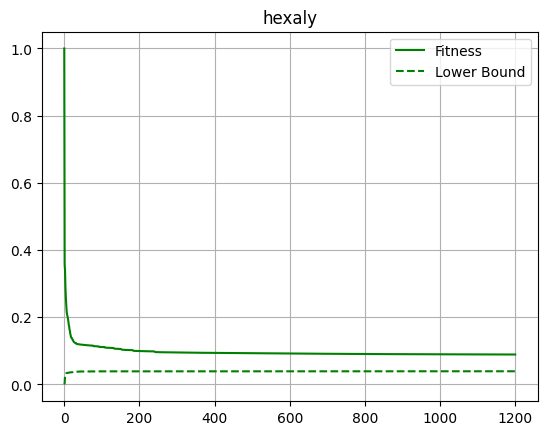

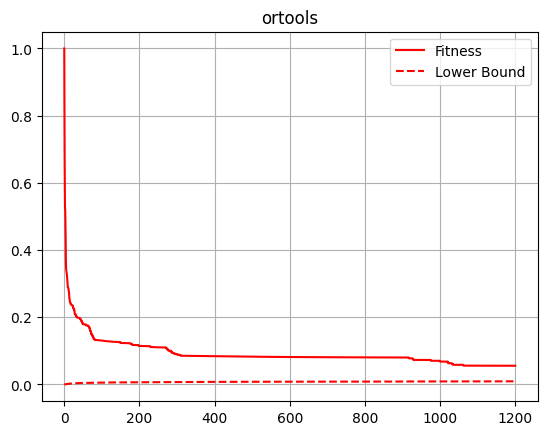

KeyError: 'ga'

In [20]:
import matplotlib.pyplot as plt
figure = plt.figure()
colors = {'cplex_cp': 'orange', 'cplex_lp': 'blue', 'hexaly': 'green', 'ortools': 'red', 'gurobi': 'cyan'}
for solver in timelines:
    t = [x[0] for x in timelines[solver]]
    f = [x[1] for x in timelines[solver]]
    lb = [x[2] for x in timelines[solver]]
    plt.plot(t, f, label=f'Fitness', linestyle='solid', c=colors[solver])
    plt.plot(t, lb, label=f'Lower Bound', linestyle='dashed', c=colors[solver])
    plt.title(solver)
    #plt.ylim(-0.01, 0.2)
    plt.legend()
    plt.show()

<Figure size 5000x1500 with 0 Axes>

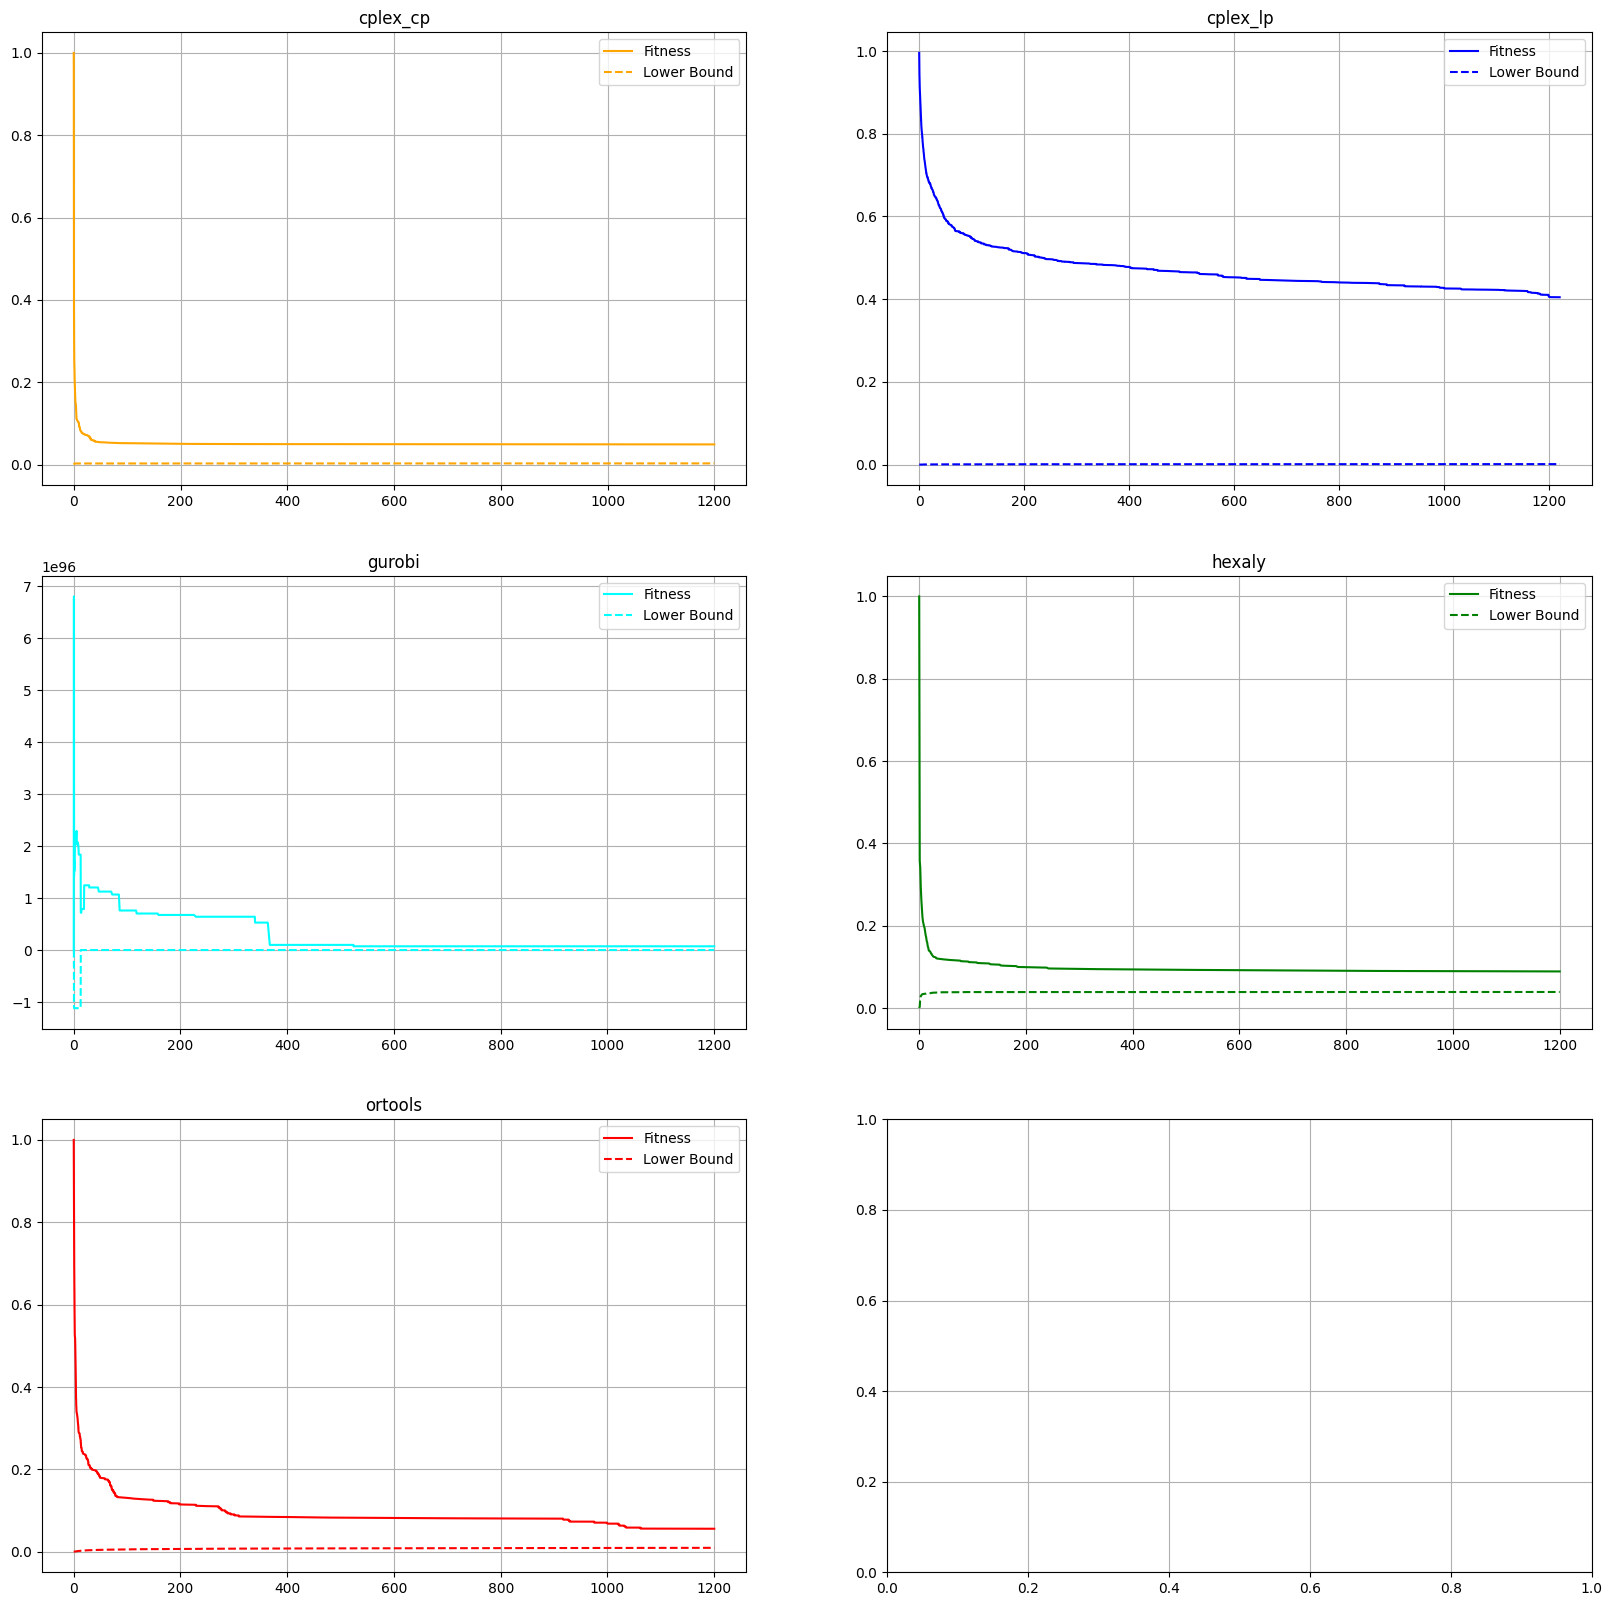

In [ ]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(50,15))
colors = {'cplex_cp': 'orange', 'cplex_lp': 'blue', 'hexaly': 'green', 'ortools': 'red', 'gurobi': 'cyan'}
fig = plt.figure(figsize=(20,20))
(a, b), (c,d), (e, f) = fig.subplots(3, 2)
ax = [a, b, c, d, e, f]
i = 0
for solver in timelines:
    t = [x[0] for x in timelines[solver]]
    f = [x[1] for x in timelines[solver]]
    lb = [x[2] for x in timelines[solver]]
    ax[i].plot(t, f, label=f'Fitness', linestyle='solid', c=colors[solver])
    ax[i].plot(t, lb, label=f'Lower Bound', linestyle='dashed', c=colors[solver])
    ax[i].set_title(solver)
    #ax[i].set_ylim(-0.01, 0.5)
    ax[i].legend()
    i+= 1
    #plt.plot(t, f, label=f'Fitness', linestyle='solid', c=colors[solver])
    #plt.plot(t, lb, label=f'Lower Bound', linestyle='dashed', c=colors[solver])
    #plt.title(solver)
    #plt.legend()
plt.show()

In [ ]:
#timestamps

In [ ]:
"""output = []
for instance in timelines:
    output.append(f'{instance};{timelines[instance]}\n')"""

"output = []\nfor instance in timelines:\n    output.append(f'{instance};{timelines[instance]}\n')"

In [ ]:
"""with open('timelines.txt', 'a') as f:
    f.writelines(output)"""

"with open('timelines.txt', 'a') as f:\n    f.writelines(output)"

In [69]:
test_data = [
    [0, 1, 1, 1, 1, 0, 0, 1, 1],
    [1, 1, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 1, 1, 1, 0, 1, 1],
    [1, 1, 1, 0, 1, 0, 1, 0, ],
    [1, 0, 1, 1, 0, 1, 0, 1, 1],
    [0, 1, 0, 1, 1, 0, 1, 1, 0]
]
values = [0.1, 0.3, 0.1, 0.2, 0.5, 0.7]

In [70]:
possible = [sum(x) for x in test_data]

In [71]:
possible

[6, 4, 6, 5, 6, 5]

In [72]:
slots = [1/x for x in possible]

In [73]:
slots

[0.16666666666666666, 0.25, 0.16666666666666666, 0.2, 0.16666666666666666, 0.2]

In [74]:
def translate(values, slots):
    return [int(values[i]/slots[i]) for i in range(len(values))]


In [75]:
translate(values, slots)

[0, 1, 0, 1, 3, 3]

In [92]:
test_data = [
    [
        [0,0,0,0],
        [1,0,1,0],
        [1,1,1,0]
    ],
    [
        [1,0,1,0],
        [1,0,0,0],
        [0,1,1,0]
    ],
    [
        [1,1,0,1],
        [0,0,1,1],
        [1,1,1,1]
    ],
]
machines = [0.1, 0.5, 0.7]
worker = [0.2, 0.6, 0.8]
def possible_machines(data):
    result = []
    for operation in data:
        result.append(0)
        for machine in operation:
            if sum(machine) > 0:
                result[-1]+=1
    return result

def possible_workers(operation):
    return [sum(operation[i]) for i in range(len(operation))]#[0] * len(operation)


In [93]:
possible_machines(test_data)

[2, 3, 3]

In [94]:
possible_workers(test_data[2])

[3, 2, 4]

In [108]:
def translate(machines, worker, data):
    m_slots = [1/x for x in possible_machines(data)]
    t_machines = [int(machines[i]/m_slots[i]) for i in range(len(machines))]
    t_worker = []
    for i in range(len(t_machines)):
        w = possible_workers(data[i])
        m = t_machines[i]
        for j in range(t_machines[i], len(w)):
            if w[j] > 0:
                break
            m+=1
        t_machines[i] = m
        w_slot = 1/(possible_workers(data[i])[t_machines[i]])
        t_worker.append(int(worker[i]/w_slot))
    return t_machines, t_worker


In [109]:
m, w = translate(machines, worker, test_data)

In [110]:
machines

[0.1, 0.5, 0.7]

In [111]:
worker

[0.2, 0.6, 0.8]

In [112]:
m

[1, 1, 2]

In [113]:
w

[0, 0, 3]

In [114]:
test_data

[[[0, 0, 0, 0], [1, 0, 1, 0], [1, 1, 1, 0]],
 [[1, 0, 1, 0], [1, 0, 0, 0], [0, 1, 1, 0]],
 [[1, 1, 0, 1], [0, 0, 1, 1], [1, 1, 1, 1]]]

In [125]:
import math
math.log(500, 10)

2.6989700043360183

In [128]:
math.log(500, 10)/500

0.0053979400086720366

In [165]:
x = []
y = []
for i in range(1, 1000):
    x.append(i)
    y.append(math.log(i, 2)/i)

In [166]:
import matplotlib.pyplot as plt

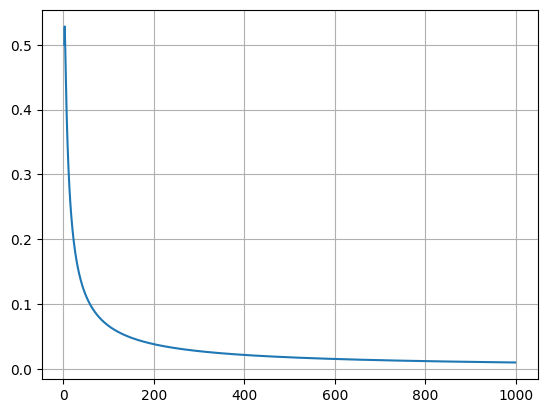

In [167]:
plt.plot(x[1:], y[1:])

In [168]:
x = []
y = []
for i in range(1, 1000):
    x.append(i)
    y.append(math.log(i, 10)/i)

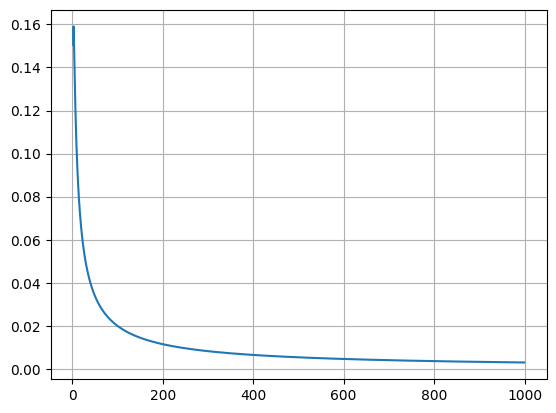

In [169]:
plt.plot(x[1:], y[1:])

In [170]:
x = []
y = []
for i in range(1, 1000):
    x.append(i)
    y.append(1/i)

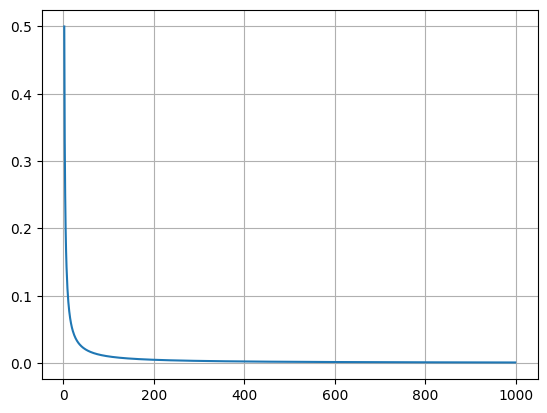

In [171]:
plt.plot(x[1:], y[1:])